# dataset_analyze

## Data Description

### Training data: train_audio/ folder

Format: .ogg audio file, sampling rate 32kHz, mono.

Each file corresponds to a recording ID, named "class_id/recording_id.ogg".

Note: Although the folder is "class", the file may not only contain the sound of this species, because it is a field recording.

### Training label: train_metadata.csv

Contains metadata such as recording_id, location, species_id.

species_id is the target label.

### Test data: test_soundscapes/

The test set is a "full scene recording", each audio is several minutes long, and the audio is cut into multiple 5-second slices (row_id).

You need to provide the probability of all 206 categories for each row_id.

### Submission format: CSV

```python-repl
row_id,species_id,probability
abc123,spec1,0.13
abc123,spec2,0.24
abc123,spec3,0.003
```
Note: The test set is multi-slice and multi-species, and you need to make probability predictions for all slices.

The training part is actually single-label multi-classification (species_id), but the test part requires giving the predicted probability of 206 birds for each slice of the entire recording - similar to an application scenario of **"multi-classification reasoning + full probability output"**. That is, during training, each training sample has a unique species_id, but during testing you must output the probability estimates for all birds (because multiple birds may appear in the environmental recording).

## Analyze the data

Total number of samples: 28564


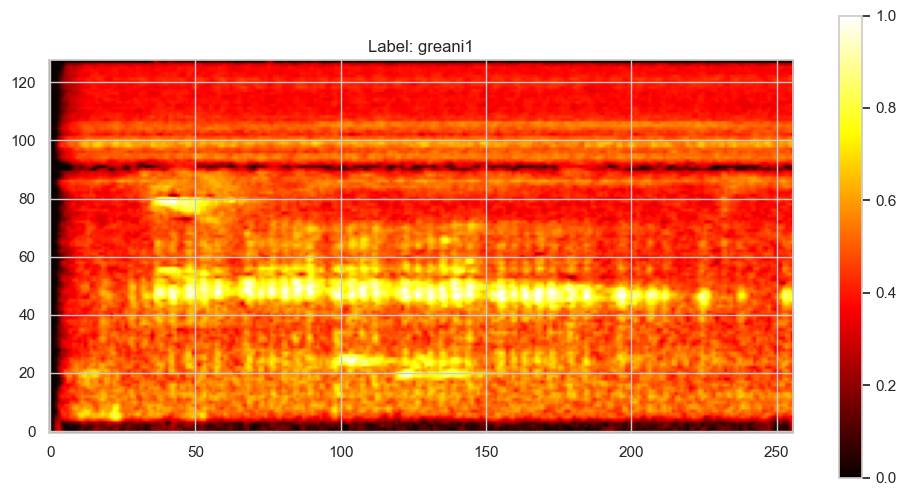

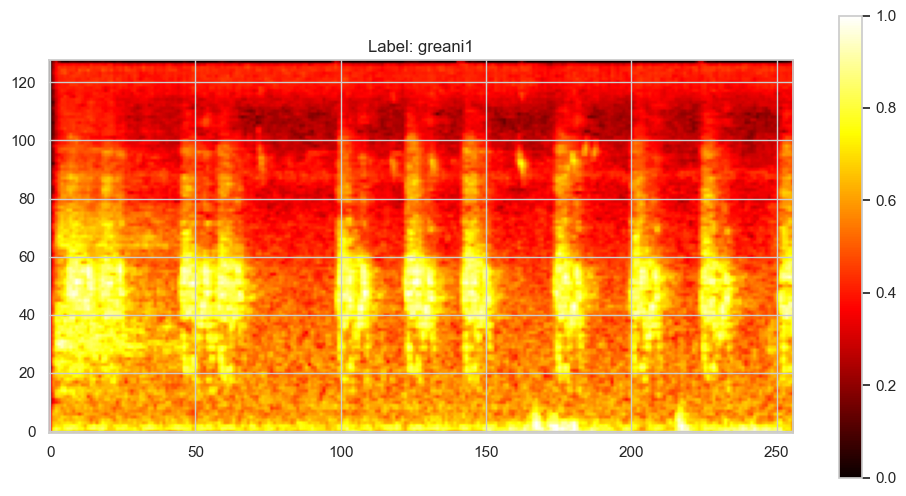

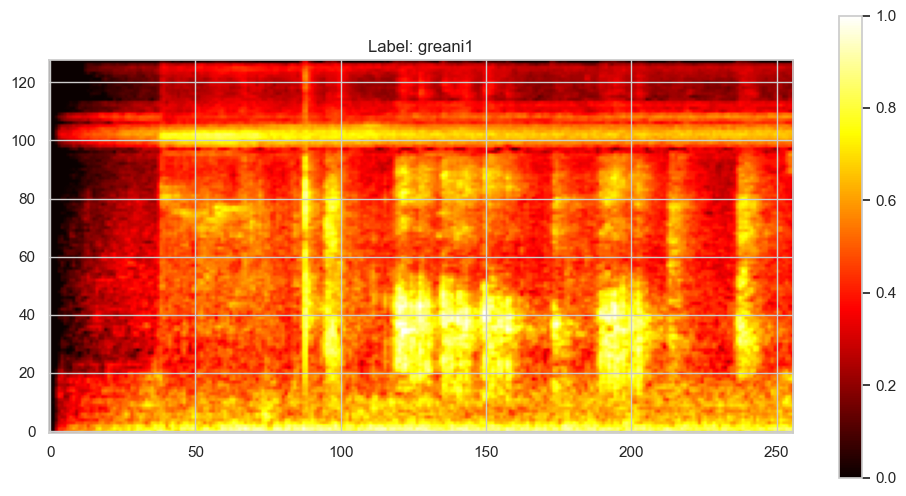

Example file: greani1_XC132190.ogg
Mel-spectrogram shape: (128, 256)
Example label: greani1
Number of unique classes: 206

Top 10 most frequent classes:
         count
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
whtdov     572
socfly1    543
yeofly1    525
bobfly1    514
wbwwre1    499

Bottom 10 least frequent classes:
       count
66531      2
21116      2
66578      2
81930      2
67082      2
66016      2
21038      2
64862      2
47067      2
42087      2


C:\Users\ab-in\AppData\Local\Temp\ipykernel_70204\4104171377.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_df.index[:50], y=label_df['count'][:50], palette='viridis')


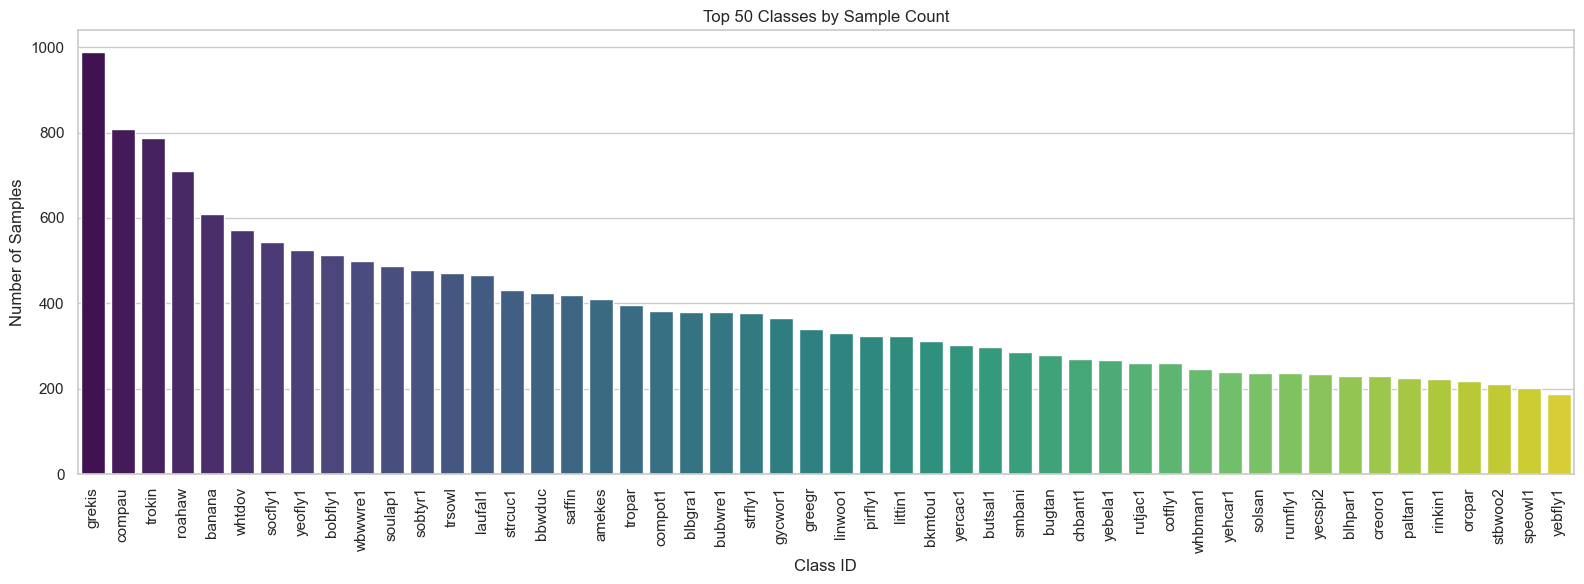

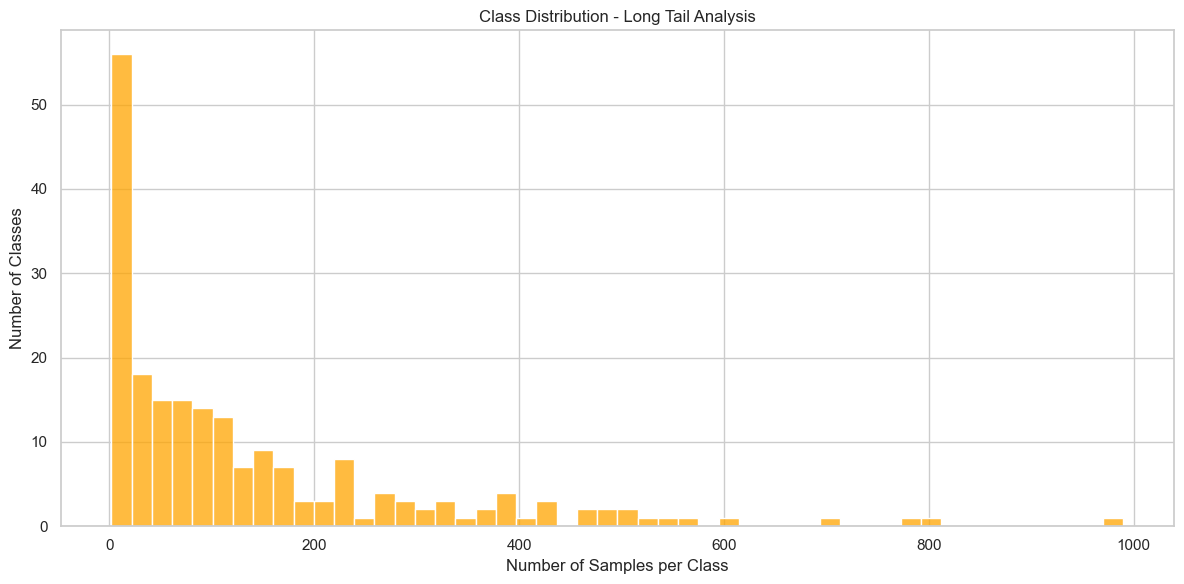


Multi-label samples: 0 (0.00%)
⚠️ Dataset appears to be single-label per sample.


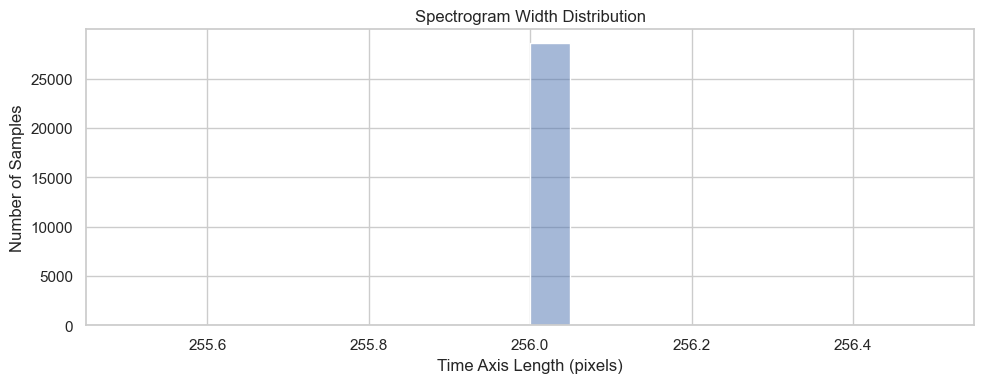

Min spectrogram width: 256
Max spectrogram width: 256
Mean spectrogram width: 256.00
Median spectrogram width: 256.0


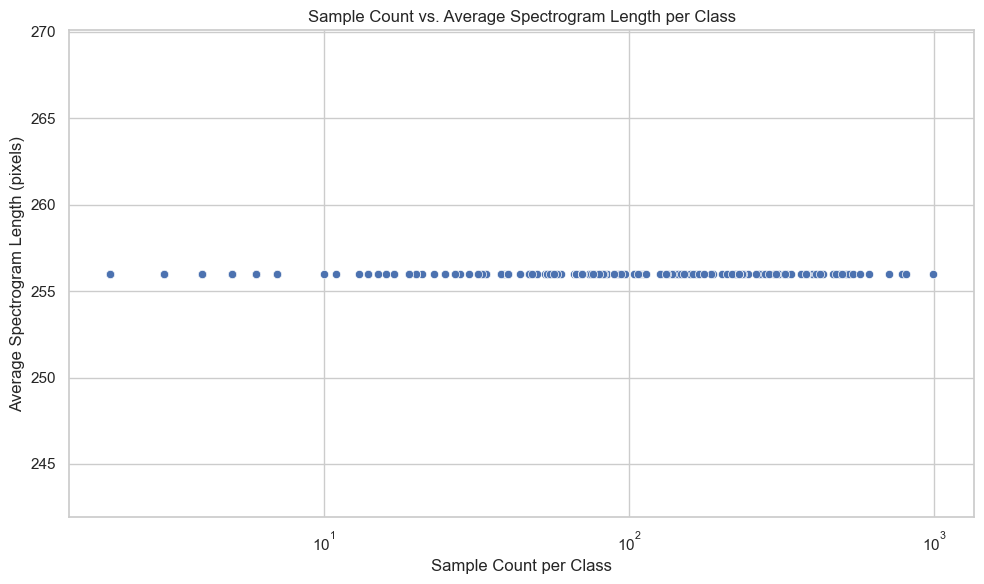

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Configure visualization
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load the data
data_path = 'dataset/train_data.npy'  # Adjust the path if needed
data_dict = np.load(data_path, allow_pickle=True).item()

print(f"Total number of samples: {len(data_dict)}")
for k in list(data_dict.keys())[:3]:
    plt.imshow(data_dict[k]['data'], cmap='hot', origin='lower')
    plt.title(f"Label: {data_dict[k]['label']}")
    plt.colorbar()
    plt.show()
# Preview the first sample
first_key = next(iter(data_dict))
print(f"Example file: {first_key}")
print(f"Mel-spectrogram shape: {data_dict[first_key]['data'].shape}")
print(f"Example label: {data_dict[first_key]['label']}")

# Initialize counters
label_counter = Counter()
multi_label_sample_counts = []

# Check labels for each sample
for file, content in data_dict.items():
    label = content['label']
    if isinstance(label, list):
        # Multi-label case
        label_counter.update(label)
        multi_label_sample_counts.append(len(label))
    else:
        # Single-label case
        label_counter.update([label])
        multi_label_sample_counts.append(1)

# Number of unique classes
num_classes = len(label_counter)
print(f"Number of unique classes: {num_classes}")

# Convert label counts to DataFrame
label_df = pd.DataFrame.from_dict(label_counter, orient='index', columns=['count'])
label_df = label_df.sort_values(by='count', ascending=False)

print("\nTop 10 most frequent classes:")
print(label_df.head(10))

print("\nBottom 10 least frequent classes:")
print(label_df.tail(10))

# Plot class distribution (top 50 classes)
plt.figure(figsize=(16, 6))
sns.barplot(x=label_df.index[:50], y=label_df['count'][:50], palette='viridis')
plt.xticks(rotation=90)
plt.title("Top 50 Classes by Sample Count")
plt.xlabel("Class ID")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

# Long-tail distribution
plt.figure(figsize=(12, 6))
sns.histplot(label_df['count'], bins=50, color='orange')
plt.title("Class Distribution - Long Tail Analysis")
plt.xlabel("Number of Samples per Class")
plt.ylabel("Number of Classes")
plt.tight_layout()
plt.show()

# Multi-label analysis
multi_label_count = sum([1 for count in multi_label_sample_counts if count > 1])
multi_label_percentage = multi_label_count / len(multi_label_sample_counts) * 100
print(f"\nMulti-label samples: {multi_label_count} ({multi_label_percentage:.2f}%)")

if multi_label_count > 0:
    print("✅ Multi-label classification detected.")
else:
    print("⚠️ Dataset appears to be single-label per sample.")

# Analyze mel-spectrogram time axis (width)
spectrogram_lengths = [content['data'].shape[1] for content in data_dict.values()]

plt.figure(figsize=(10, 4))
sns.histplot(spectrogram_lengths, bins=20, kde=True)
plt.title("Spectrogram Width Distribution")
plt.xlabel("Time Axis Length (pixels)")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

# Summary statistics for spectrogram length
print(f"Min spectrogram width: {np.min(spectrogram_lengths)}")
print(f"Max spectrogram width: {np.max(spectrogram_lengths)}")
print(f"Mean spectrogram width: {np.mean(spectrogram_lengths):.2f}")
print(f"Median spectrogram width: {np.median(spectrogram_lengths)}")

# Optional: Correlation between label frequency and average spectrogram length
label_lengths = {}
for file, content in data_dict.items():
    label = content['label']
    length = content['data'].shape[1]
    if isinstance(label, list):
        for l in label:
            label_lengths.setdefault(l, []).append(length)
    else:
        label_lengths.setdefault(label, []).append(length)

avg_lengths = {label: np.mean(lengths) for label, lengths in label_lengths.items()}

avg_length_df = pd.DataFrame({
    'label': list(avg_lengths.keys()),
    'average_length': list(avg_lengths.values()),
    'sample_count': [label_counter[l] for l in avg_lengths.keys()]
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=avg_length_df, x='sample_count', y='average_length')
plt.title("Sample Count vs. Average Spectrogram Length per Class")
plt.xlabel("Sample Count per Class")
plt.ylabel("Average Spectrogram Length (pixels)")
plt.xscale('log')
plt.tight_layout()
plt.show()
